In [18]:
import numpy as np
import torch
from sb3_contrib import TRPO
import pickle
import random
from tqdm.notebook import tqdm
from stable_baselines3.common.callbacks import BaseCallback
from PracticeProblemEnv import PracticeProblemEnv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# Callback, measure the performance of the model
class ProgressCallback(BaseCallback):
    def __init__(self, total_timesteps, verbose=1):
        super(ProgressCallback, self).__init__(verbose)
        self.total_timesteps = total_timesteps
        self.episode_rewards = []  # To store rewards of each episode
        self.rewards = []
        self.current_episode_reward = 0  # Reward accumulator for the current episode
        self.pbar = None

    def _on_training_start(self):
        self.pbar = tqdm(total=self.total_timesteps, desc="Training Progress")

    def _on_step(self):
        reward = self.locals["rewards"][0] # get the reward of the current step, assume there is only one env
        self.current_episode_reward += reward  # Accumulate rewards for the current episode
        self.rewards.append(reward)
        self.pbar.update(1)

        # Check if episode has ended
        done = self.locals["dones"][0]  # Check if the episode is done
        if done:
            self.episode_rewards.append(self.current_episode_reward)  # Save total reward for this episode
            self.current_episode_reward = 0  # Reset for the next episode
        
        # if self.n_calls % 1000 == 0:
            # if self.episode_rewards:  # Ensure there is at least one episode completed
                # ep_rew_mean = sum(self.episode_rewards) / len(self.episode_rewards)
                # tqdm.write(f"Step: {self.n_calls}, Episode mean reward: {ep_rew_mean}")
        return True
    def _on_training_end(self):
        self.pbar.close()


In [ ]:
with open('result/akt_pid/assist2009_pid/args.pkl', 'rb') as f:
    params = pickle.load(f)
print(params)

In [22]:
env = PracticeProblemEnv(params,max_step=100, QperS=1, rew_func='mock', n_PperQ=10, units = [1], device=device)

# Define and train the TRPO model
model = TRPO('MlpPolicy', env, verbose=1)

# self-defined callback
total_timesteps = 1
callback = ProgressCallback(total_timesteps=total_timesteps)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [23]:
model.learn(total_timesteps=total_timesteps, callback=callback)

Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.3     |
|    ep_rew_mean     | 18.4     |
| time/              |          |
|    fps             | 48       |
|    iterations      | 1        |
|    time_elapsed    | 42       |
|    total_timesteps | 2048     |
---------------------------------


In [27]:
# print(callback.episode_rewards)

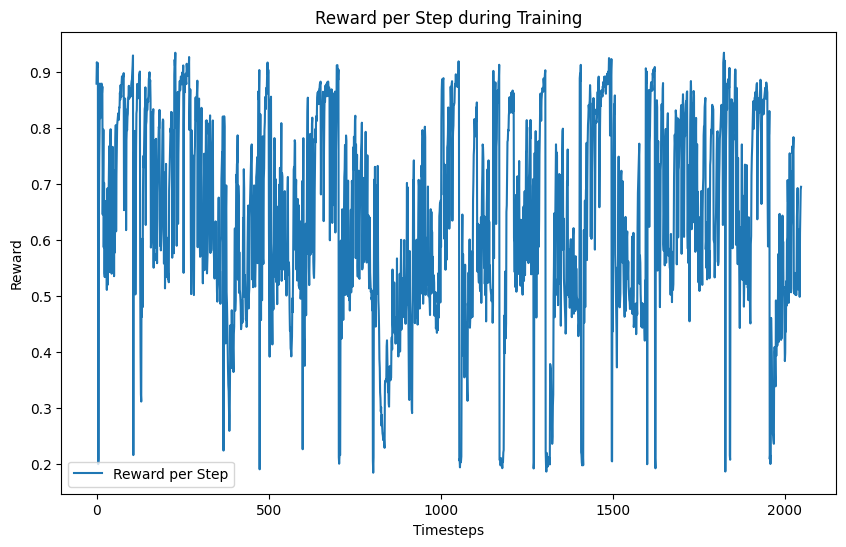

In [25]:
# 训练完成后，绘制奖励的可视化图
from matplotlib import pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(callback.rewards, label='Reward per Step')
plt.xlabel('Timesteps')
plt.ylabel('Reward')
plt.title('Reward per Step during Training')
plt.legend()
plt.show()

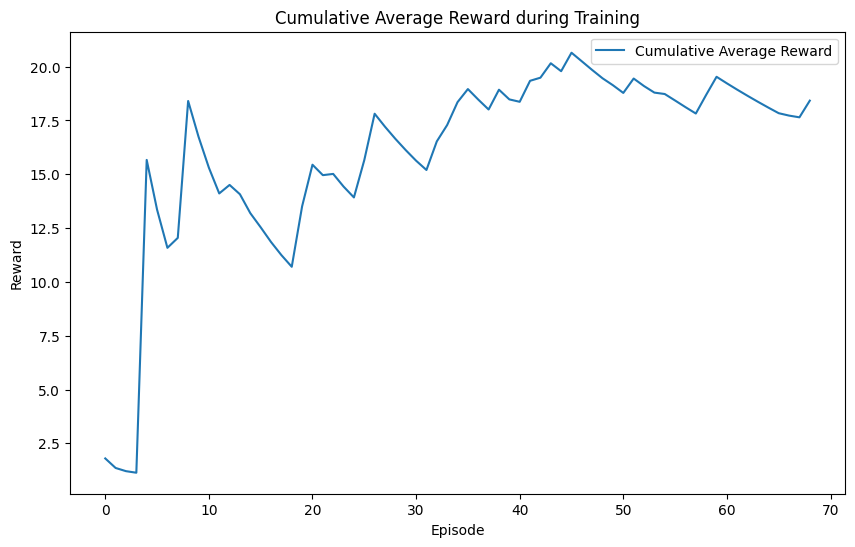

In [26]:
episode_rewards = callback.episode_rewards
cumulative_average = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_average, label='Cumulative Average Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Cumulative Average Reward during Training')
plt.legend()
plt.show()

In [ ]:
print(f"episode_rewards: {callback.episode_rewards}")

In [31]:
# save the rewards
import pickle

data_to_save = {
    'episode_rewards': callback.episode_rewards,
    'rewards': callback.rewards
}

with open('saved_rewards.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

# save the env
with open('env.pkl', 'wb') as f:
    pickle.dump(env, f)

In [32]:
# load the env
with open('env.pkl', 'rb') as f:
    env = pickle.load(f)
# load the rewards
with open('saved_rewards.pkl', 'rb') as f:
    data = pickle.load(f)

In [33]:
# model.save("model_1000_100_mock1")
# model.load("model_1000_100_mock1")

## Evaluation Space

In [19]:
# Test the trained model
# model.load("model_1000_100_mock1")

obs, _ = env.reset()
env.switch_rew("correct")
obs_list = []
total_rewards = []
k=100
for _ in range(k):
    action, _states = model.predict(obs)
    obs, rewards, terminated, truncated, info = env.step(action)
    total_rewards.append(rewards)
    obs_list.append(obs)
    if terminated or truncated:
        obs, _ = env.reset()

## Experimental Space

In [13]:
import gymnasium as gym

test = gym.spaces.Box(low=np.array([[low]*5 for low in [1,0,1]]), 
                                                high=np.array([[high]*5 for high in [100, 1, 1000]]),
                                                shape=(3,5),
                                                dtype=np.int32
                                                ) 
test1 = gym.spaces.MultiDiscrete([100] * 5)

In [16]:
[-1]*5

[-1, -1, -1, -1, -1]

In [15]:
test.sample()

array([[ 11,  49,  24,   7,  34],
       [  1,   0,   0,   1,   1],
       [559, 992, 826, 144, 420]])

In [14]:
test1.sample()

array([99, 93, 85, 41, 79], dtype=int64)

In [17]:
np.array([[-1]*5,[-1]*5,[-1]*5])

array([[-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

In [15]:
obs, rewards, terminated, truncated, info = env.step(np.array(75))

In [16]:
env.q_p_dict
sampled_concpets = []
sampled_problems = []
n_problems_per_type = 10
for question_type, question_ids in env.q_p_dict.items():
    num = min(n_problems_per_type, len(question_ids))
    sampled_problems += random.sample([*question_ids], num)
    sampled_concpets += ([question_type ] * num)

In [17]:
# sampled_problems = sampled_problems[:1]
# sampled_concpets = sampled_concpets[:1]

In [18]:
test_n_problem = len(sampled_problems)
q = torch.cat((torch.tensor(env.history['q'][-(env.params.seqlen-1):]).tile((test_n_problem,1)),(torch.tensor(sampled_concpets).unsqueeze(-1))),1)
target = torch.tensor(env.history['target'][-(env.params.seqlen-1):]+[0]).tile((test_n_problem,1))
pid = torch.cat((torch.tensor(env.history['pid'][-(env.params.seqlen-1):]).tile((test_n_problem,1)),(torch.tensor(sampled_problems).unsqueeze(-1))),1)
assert pid.shape == target.shape == pid.shape #(test_n_problem,3)
qa = q+target*env.params.n_question

In [19]:
padded_q = torch.zeros((test_n_problem, env.params.seqlen)) 
padded_qa = torch.zeros((test_n_problem, env.params.seqlen))
padded_target = torch.full((test_n_problem,env.params.seqlen),-1)
padded_pid = torch.zeros((test_n_problem, env.params.seqlen))

In [20]:
pred_index = q.shape[1]
padded_q[:, :pred_index]= q
padded_qa[:, :pred_index]= qa
padded_target[:, :pred_index]= target
padded_pid[:, :pred_index]= pid

In [21]:
q = padded_q.long().to(device)
qa = padded_qa.long().to(device)
target = padded_target.long().to(device)
pid = padded_pid.long().to(device)

In [22]:
with torch.no_grad():
    loss, pred, ct = env.kt_model(q,qa,target,pid)

In [23]:
nopadding_index = np.flatnonzero(padded_target.reshape((-1,)) >= -0.9).tolist()
pred_nopadding = pred[nopadding_index]

In [24]:
test_result = pred_nopadding[(pred_index-1)::pred_index]
assert test_result.shape == (test_n_problem,)
mean_performance = test_result.mean().item()
# return mean_performance